# apply instruments settings

In [169]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config_custom as hdc

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np
import matplotlib.pyplot as plt

In [170]:
# connect to devices
pg  = PulseGenerator(ip=hdc.PS_IP, chmap=hdc.PS_chmap) 
mwsyn = Synthesizer(hdc.VDISYN_SN, 
                    vidpid=hdc.VDISYN_VIDPID,
                    baudrate=hdc.VDISYN_BAUD, 
                    timeout=5, 
                    write_timeout=5)
# mwsyn.reboot()
laser = LaserControl(hdc.LASER_SN)
laser.open()
# mwsyn.close()
# laser.close()


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


# Set parameters

In [171]:
current_percent = 90.05
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(current_percent, save_memory=False)

In [172]:
laser.laser_off()

In [186]:
laserpower = 1.0
laser.laser_off()
laser.set_analog_control_mode("power")
laser.set_modulation_state("CW")
laser.set_laser_power(laserpower, save_memory=False)
# laser.laser_on()

In [173]:
f_NVguess = 398.5607725381851
f_NVguess = 398.5547716319561
# f_NVguess = 392.83677300810814
f_NVguess = 392.8397714495659
freq = f_NVguess/24.0

errorbyte, freq_actual = mwsyn.cw_frequency(freq)
print(f"CW Freqeuncy Setting Sent:{freq} GHz")
print(f"Actual Output CW Freqeuncy :{freq_actual} GHz")

CW Freqeuncy Setting Sent:16.36832381039858 GHz
Actual Output CW Freqeuncy :16.36832381039858 GHz


In [189]:
DAQclockbase = 100.00/1E3 # GHz
DAQtimebase = 1.0/DAQclockbase #ns
laser_init = 6400
wait_init = 800
mw_dur_start = 10.0
mw_dur_stop = 2400
mw_dur_step = 16.0
mw_dur = np.arange(mw_dur_start, mw_dur_stop+mw_dur_step, mw_dur_step)
# mw_dur = np.geomspace(mw_dur_start, mw_dur_stop, 320, endpoint=True)
# rounding is IMPORTANT!!
# mw_dur = np.round(DAQclockbase*mw_dur)*DAQtimebase # round to DAQ timebase
mw_dur = np.round(mw_dur) # round to PS timebase
mw_dur_stop = mw_dur[-1]
mw_dur_start = mw_dur[0]
wait_read = 300
laser_read = 800

# here is to fix the timing
totaltime_max = laser_init+wait_init+mw_dur_stop+wait_read+laser_read
tbmultiple = int(DAQclockbase*totaltime_max+1)
sampling_rate = DAQclockbase/tbmultiple
sampletime = round(1.0/sampling_rate)
samplerate = 1.0/sampletime #GHz
padding_fix = sampletime-totaltime_max
padding = padding_fix+mw_dur_stop-mw_dur # depends on MW duration
num_pt = len(mw_dur)

assert np.all(padding+mw_dur+laser_init+wait_init+wait_read+laser_read == sampletime)
assert padding_fix >= 0


In [190]:
# readoffset = DAQtimebase*30
delaydiff = DAQtimebase*15.0
readoffset = DAQtimebase*25.0
# delaydiff = DAQtimebase*0.0
# readoffset = laser_read - 20
daqpadding = sampletime - (laser_read - readoffset - delaydiff)
daqpadding = int(DAQclockbase*daqpadding)/DAQclockbase
# daqdelay = DAQtimebase*20.0
daqdelay = 0.0
daqtriggerdelay = DAQtimebase*0.0
# daqpadding = 1.0/clock_rate*1.0
# daqpadding = int(clock_rate*(1.0/sampling_rate-(laser_read-250.0)))/clock_rate
# daqpadding = 0.0


seq_daqtrig = [(daqdelay, LOW)] + [(daqtriggerdelay, LOW)] + [(daqpadding-DAQclockbase*10, LOW)] + [(sampletime, HIGH), (sampletime*(num_pt*2 - 1) - daqtriggerdelay-daqpadding+DAQclockbase*10, LOW)]
# seq_clock = [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]*(num_pt*2*clockmultiple+int(daqpadding*clock_rate))
# seq_clock = [(daqpadding, LOW)] + [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]*(num_pt*2*clockmultiple)
seq_clock = [(daqdelay, LOW)] + [(daqpadding, LOW),(sampletime-daqpadding, HIGH)]*num_pt*2
# seq_clock = [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]

seq_laser = []
seq_mwA = []
seq_mwB = []
skip = 0
seq_laser_sub_alloff = [(padding[-1], LOW), (laser_init, LOW), (wait_init, LOW), (mw_dur[-1], LOW), (wait_read, LOW), (laser_read, LOW)]
# for mwd, pd in zip(mw_dur, padding):
for ii in range(len(mw_dur)-skip):
    mwd = mw_dur[ii]
    pd = padding[ii]
    seq_laser_sub = [(pd, LOW), (laser_init, HIGH), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, HIGH)]
    seq_mwA_sub = [(pd, LOW), (laser_init, LOW), (wait_init, LOW), (mwd, HIGH), (wait_read, LOW), (laser_read, LOW)]
    seq_mwA_noMW_sub = [(pd, LOW), (laser_init, LOW), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, LOW)]
    # seq_laser_sub = [(laser_init, HIGH), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, HIGH), (pd, LOW)]
    # seq_mwA_sub = [(laser_init, LOW), (wait_init, LOW), (mwd, HIGH), (wait_read, LOW), (laser_read, LOW), (pd, LOW)]
    # seq_mwA_noMW_sub = [(laser_init, LOW), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, LOW), (pd, LOW)]
    seq_laser += seq_laser_sub + seq_laser_sub
    # seq_laser += seq_laser_sub + seq_laser_sub_alloff
    seq_mwA += seq_mwA_sub + seq_mwA_noMW_sub
    seq_mwB += seq_mwA_noMW_sub + seq_mwA_noMW_sub
    # seq_mwA += seq_mwA_sub + seq_mwA_sub
    # seq_mwA += seq_mwA_noMW_sub + seq_mwA_noMW_sub
    # seq_mwA += seq_mwA_sub + seq_mwA_sub
seq_laser += (seq_laser_sub_alloff + seq_laser_sub_alloff)*skip
seq_mwA += (seq_mwA_noMW_sub + seq_mwA_noMW_sub)*skip
seq_mwB += (seq_mwA_noMW_sub + seq_mwA_noMW_sub)*skip
seq_laser +=  [(daqdelay, LOW)]
seq_mwA +=  [(daqdelay, LOW)]
seq_mwB +=  [(daqdelay, LOW)]
# seq_laser = [(daqtrigdelay,LOW)] + seq_laser
# seq_laser = [(0.5/clock_rate, HIGH),(0.5/clock_rate, HIGH)]*(num_pt*2*clockmultiple+int(daqtrigdelay*clock_rate))
# seq_mwA = [(daqtrigdelay,LOW)] + seq_mwA
# seq_laser += [(daqpadding, LOW)]
# seq_mwA += [(daqpadding, LOW)]

rrr = 8
pg.setDigital("laser", seq_laser*rrr)
pg.setDigital("mw_A", seq_mwA*rrr)
pg.setDigital("mw_B", seq_mwB*rrr)
# pg.setDigital("laser", seq_mwA)
# pg.setDigital("mw_A", seq_laser)
pg.setDigital("daqtrig", seq_daqtrig*rrr)
pg.setDigital("clock", seq_clock*rrr)
pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)
assert round(np.sum(np.array(seq_laser)[:, 0])) == round(np.sum(np.array(seq_mwA)[:, 0])) == round(np.sum(np.array(seq_daqtrig)[:, 0])) == round(np.sum(np.array(seq_clock)[:, 0]))
assert sampletime > daqpadding + 10

In [191]:
aa = np.sum(np.array(seq_laser)[:, 0])
print(f"Total Seq. Time: {np.sum(aa)}ns")
aa = np.array(seq_mwA)[:, 0]
print(f"Total Seq. Time: {np.sum(aa)}ns")
aa = np.array(seq_daqtrig)[:, 0]
print(f"Total Seq. Time: {np.sum(aa)}ns")
aa = np.array(seq_clock)[:, 0]
print(f"Total Seq. Time: {np.sum(aa)}ns")

Total Seq. Time: 3237440.0ns
Total Seq. Time: 3237440.0ns
Total Seq. Time: 3237440.0ns
Total Seq. Time: 3237440.0ns


In [193]:
# signal reading parameters
min_volt = -0.001 # [V]
max_volt = 0.003
samplerate_read = samplerate*1E9 # 500kHz .max ext clock rate of NI6343, check it by yourself!
num_readsample = num_pt*2
timeout_read = max(2*num_readsample/samplerate_read, 10)
buffer_readpoint = np.zeros(num_readsample, dtype=np.float64, order='C')

readtask = nidaqmx.Task("readsignal")
# readtask.close()
readtask.ai_channels.add_ai_voltage_chan(
            hdc.DAQch_APD,"",
            # TerminalConfiguration.RSE,
            TerminalConfiguration.DIFF,
            min_volt,max_volt,
            VoltageUnits.VOLTS
        )
# readtask.timing.cfg_samp_clk_timing(samplerate_read, source="", active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=num_readsample)
readtask.timing.cfg_samp_clk_timing(
    samplerate_read, 
    source=hdc.DAQch_Clock, 
    active_edge=Edge.RISING, 
    sample_mode=AcquisitionType.CONTINUOUS, 
    # sample_mode=AcquisitionType.FINITE, 
    samps_per_chan=num_readsample)
read_trig = readtask.triggers.start_trigger
read_trig.cfg_dig_edge_start_trig(hdc.DAQch_Trig, Edge.RISING)

reader = AnalogSingleChannelReader(readtask.in_stream)
reader.read_all_avail_samp  = True

In [192]:
readtask.close()

# Start measurement


In [155]:
laser.laser_on() # turn on laser

In [194]:
laser.laser_off() # turn on laser

In [197]:
pg.stream(n_runs=INF)
pg.startNow()
# signal = np.zeros(num_pt)
# background = np.zeros(num_pt)
# repeat measurement

signal_av = np.zeros(num_pt, dtype=np.float64, order='C')
background_av = np.zeros(num_pt, dtype=np.float64, order='C')
readtask.start() # ready to read data
read_duration = 60  # read data for 5 seconds
start_time = time.time()
num_repeat = 0
while time.time() - start_time < read_duration:
# for kkk in range(num_repeat):
    # readtask.start() # ready to read data
    num_read = reader.read_many_sample(
            buffer_readpoint,
            num_readsample,
            timeout_read
        )
    # readtask.wait_until_done(timeout=timeout_read) # block the code below, optional
    signal_av += np.copy(buffer_readpoint[0::2])
    background_av += np.copy(buffer_readpoint[1::2])
    # readtask.stop()
    num_repeat += 1
readtask.stop()
# laser.laser_off()
# readtask.close()
signal_av = signal_av/num_repeat
background_av = background_av/num_repeat
contrast = (signal_av-background_av)/background_av
print(f"measurement repeat : {num_repeat} times")

measurement repeat : 18530 times


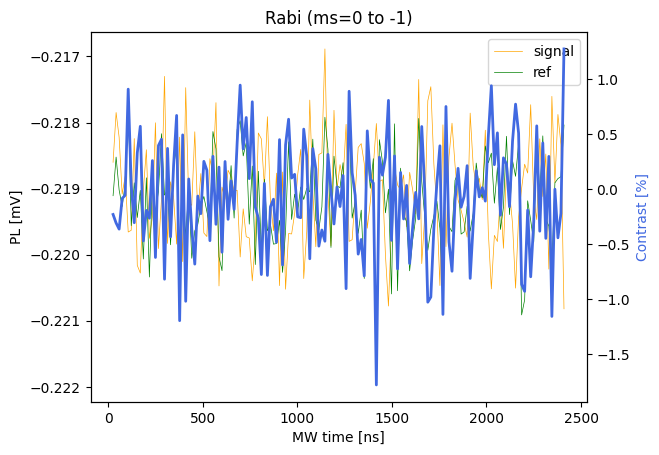

: 

In [198]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# ax1.plot(mw_dur, signal_av*1E3, linewidth=0.5, label="signal", color="orange")
# ax1.plot(mw_dur, background_av*1E3, linewidth=0.5, label="ref", color="green")
# ax2.plot(mw_dur, contrast*100.0, linewidth=2, label="contrast", color='royalblue')
idxstart = 1
idxend = len(mw_dur)
# idxend = 200
ax1.plot(mw_dur[idxstart:idxend], signal_av[idxstart:idxend]*1E3, linewidth=0.5, label="signal", color="orange")
ax1.plot(mw_dur[idxstart:idxend], background_av[idxstart:idxend]*1E3, linewidth=0.5, label="ref", color="green")
ax2.plot(mw_dur[idxstart:idxend], contrast[idxstart:idxend]*100.0, linewidth=2, label="contrast", color='royalblue')

ax1.set_xlabel("MW time [ns]")
ax1.set_ylabel("PL [mV]")
ax2.set_ylabel("Contrast [%]", color='royalblue')
ax1.legend(loc='best')
plt.title("Rabi (ms=0 to -1)")
plt.show()

In [158]:
# to save file
# Data to save
import pickle
data = {
    'mw_dur': mw_dur,
    'freq_actual': freq_actual,
    'signal_av': signal_av,
    'background_av': background_av, 
    'contrast': contrast, 
}

# File path
filename = f"m1rabi_ccw_wi_init6400nsthplasticmetalholder_range{mw_dur_stop}us_z70um.pkl"
dir = "output\\20240506_eveningmeasurementdebug"
file_path = f'{dir}\\{filename}'

# Open the file in binary write mode
with open(file_path, 'wb') as f:
    # Write data to the file using pickle.dump()
    pickle.dump(data, f)

print(f'Data saved to {file_path}')

Data saved to output\20240506_eveningmeasurementdebug\m1rabi_ccw_wi_init6400nsthplasticmetalholder_range2442.0us_z70um.pkl


In [159]:
# File path
file_path = file_path
# file_path = "output\\20240508_coherence_measurement\\m1fid_400.0nspihalf_392.8397714495659.pkl"
# Open the file in binary read mode
with open(file_path, 'rb') as f:
    # Read data from the file using pickle.load()
    data = pickle.load(f)

# Access your data variables
mw_dur = data['mw_dur']
freq_actual = data['freq_actual']
signal_av = data['signal_av']
background_av = data['background_av']
contrast = data['contrast']

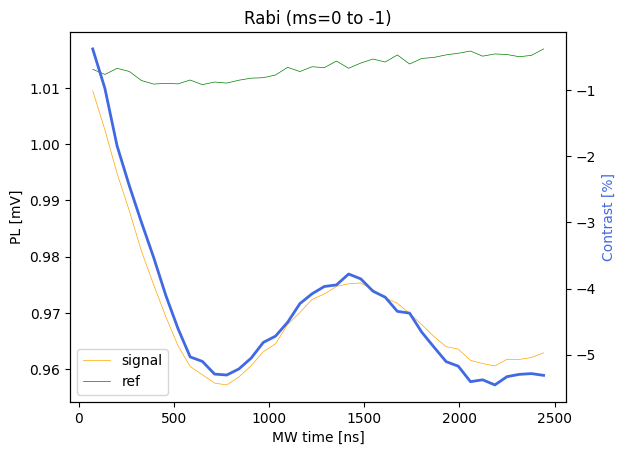

In [160]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# ax1.plot(mw_dur, signal_av*1E3, linewidth=0.5, label="signal", color="orange")
# ax1.plot(mw_dur, background_av*1E3, linewidth=0.5, label="ref", color="green")
# ax2.plot(mw_dur, contrast*100.0, linewidth=2, label="contrast", color='royalblue')
idxstart = 1
idxend = len(mw_dur)
# idxend = 500
ax1.plot(mw_dur[idxstart:idxend], signal_av[idxstart:idxend]*1E3, linewidth=0.5, label="signal", color="orange")
ax1.plot(mw_dur[idxstart:idxend], background_av[idxstart:idxend]*1E3, linewidth=0.5, label="ref", color="green")
ax2.plot(mw_dur[idxstart:idxend], contrast[idxstart:idxend]*100.0, linewidth=2, label="contrast", color='royalblue')

ax1.set_xlabel("MW time [ns]")
ax1.set_ylabel("PL [mV]")
ax2.set_ylabel("Contrast [%]", color='royalblue')
ax1.legend(loc='best')
plt.title("Rabi (ms=0 to -1)")
plt.show()

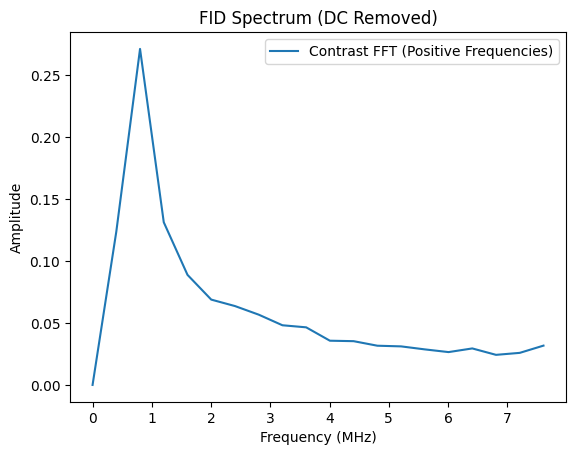

In [164]:
# Access the contrast data and time domain
contrast = data['contrast']
mw_dur = data['mw_dur']

# Remove the DC component (constant offset) by subtracting the mean
contrast_centered = contrast - np.mean(contrast)
# contrast_centered = contrast

# Perform the FFT after removing DC
# Convert fid_dur from nanoseconds to seconds for correct frequency calculation
sampling_interval = (mw_dur[1] - mw_dur[0]) * 1e-3  # Convert ns to us

# Compute FFT and corresponding frequencies
contrast_fft = np.fft.fft(contrast_centered)
frequencies = np.fft.fftfreq(len(contrast_centered), sampling_interval)

# Filter out the negative frequencies
positive_frequencies = frequencies[frequencies >= 0]
positive_fft = contrast_fft[frequencies >= 0]

# Plot only the positive frequencies
plt.figure()
plt.plot(positive_frequencies, np.abs(positive_fft), label='Contrast FFT (Positive Frequencies)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')
plt.title('FID Spectrum (DC Removed)')
plt.legend()
plt.savefig(f"{'.'.join(file_path.split('.')[0:-1])}_fft.jpg")

In [162]:
from scipy.optimize import curve_fit
# Define Lorentzian function
def lorentzian(x, amplitude, center, width):
    return amplitude / (1.0 + ((x - center) / width) ** 2)

# Perform the FFT (with DC removal)
sampling_interval = (mw_dur[1] - mw_dur[0]) * 1e-9  # Convert ns to s
contrast_fft = np.fft.fft(contrast_centered)

# Get the positive frequencies and their FFT results
frequencies = np.fft.fftfreq(len(contrast_centered), sampling_interval)
positive_indices = frequencies >= 0
positive_frequencies = frequencies[positive_indices]
positive_fft = contrast_fft[positive_indices]

# Get the magnitude of the positive FFT
fft_magnitude = np.abs(positive_fft)

# Identify peak regions for fitting
threshold = 0.6 * np.max(fft_magnitude[80:])  # Relative threshold
peak_indices = list(np.array(np.where(fft_magnitude[80:] > threshold)[0]) + 80)

# Group peak indices to identify unique peaks and double their range
peak_groups = []
current_group = []

# Identify groups of peaks
for i in peak_indices:
    if not current_group:
        current_group.append(i)
    elif i - current_group[-1] <= 5:
        current_group.append(i)
    else:
        peak_groups.append(current_group)
        current_group = [i]

# Add any remaining group
if current_group:
    peak_groups.append(current_group)

# Extend each group by doubling its range
extended_peak_groups = []
for group in peak_groups:
    # Extend the start and end of each group by doubling its length
    start = max(0, group[0] - 20*len(group))  # Ensure it doesn't go below zero
    end = min(len(positive_frequencies) - 1, group[-1] + 20*len(group))  # Ensure it doesn't go out of bounds
    extended_peak_groups.append(list(range(start, end)))

# Fit Lorentzian to each extended peak group
fitted_peaks = []
plt.figure()
plt.plot(positive_frequencies, fft_magnitude, label="Original FFT")

# Increase maxfev for more complex fittings
maxfev = 2000  # Adjust as needed

# Iterate over each extended peak group for fitting
for group in extended_peak_groups:
    # Get the mid-point of the group as the initial guess for the center
    initial_center = positive_frequencies[group[len(group) // 2]]
    initial_amplitude = fft_magnitude[group[len(group) // 2]]
    initial_width = 1e6  # An initial guess for width

    try:
        # Perform curve fitting with constraints and bounds
        popt, _ = curve_fit(
            lorentzian,
            positive_frequencies[group],
            fft_magnitude[group],
            p0=[initial_amplitude, initial_center, initial_width],
            maxfev=maxfev,
            bounds=([0, initial_center - 5e6, 1e5], [np.inf, initial_center + 5e6, 1e7]),  # Constrained bounds
        )

        # Extract fitted parameters
        amplitude, center, width = popt
        fitted_peaks.append(center)

        # Plot the fitted Lorentzian curve
        plt.plot(
            positive_frequencies,
            lorentzian(positive_frequencies, amplitude, center, width),
            '--',
            label=f"Fitted Lorentzian (Center: {center:.2e} Hz)",
        )
    except RuntimeError:
        print(f"Could not fit Lorentzian for peak group centered at {initial_center:.2e} Hz")

# Zoom in to the fitted peak regions
peak_centers = np.array(fitted_peaks)
zoom_margin_lower = 0.5e6  # Adjust as needed for lower margin
zoom_margin_higher = 1.5e6  # Adjust as needed for upper margin

plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT with Lorentzian Fits (Zoomed In)")
plt.legend()
plt.xlim(max(0, peak_centers.min() - zoom_margin_lower), peak_centers.max() + zoom_margin_higher)  # Set x-axis limits to zoom
plt.ylim(0, 1)
# Output the fitted peak frequencies
print("Fitted peak frequencies:")
for peak in fitted_peaks:
    print(f"{peak:.2e} Hz")

ValueError: zero-size array to reduction operation maximum which has no identity

In [52]:
1/725/2

0.000689655172413793

In [165]:
pg.constant(OutputState.ZERO())
laser.laser_off() # turn off laser
readtask.close()
# mwsyn.reboot()

In [166]:
mwsyn.reboot()

MW Synthesizer Rebooted!


In [167]:
# close the communication
laser.close()
mwsyn.close()


In [168]:
pg.reset()